# Multiple Gravity Assist (MGA)

In this tutorial, we show the use of the {class}`pykep.trajopt.mga` to design an interplanetary trajectory through multiple planetary encounters, 
allowing for propulsion manovures in the form of instantaneous $\Delta V$ immediately after each fly-by.



In [8]:
import pykep as pk
import pygmo as pg
import matplotlib.pyplot as plt

In [9]:
udp = pk.trajopt.mga()
prob = pg.problem(udp)
uda = pg.cmaes(1500, force_bounds=True, sigma0=0.5, ftol=1e-4)
#uda = pg.sade(4500)
algo = pg.algorithm(uda)
res = list()
for i in range(1):
    pop = pg.population(prob, 100)
    pop = algo.evolve(pop)
    res.append(pop.champion_f)
    print(i, flush=True)

0


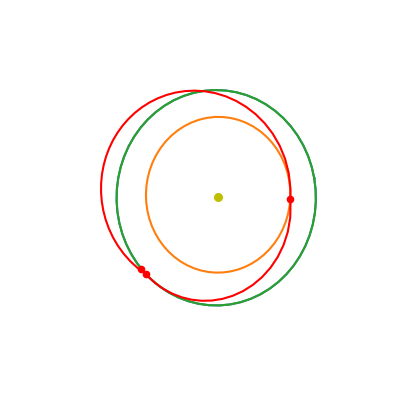

In [10]:
ax = udp.plot(pop.champion_x, figsize=(5,5))
ax.view_init(90,0)
ax.axis('off');


(-1.150591947301098,
 1.1494267321191918,
 -1.3449433682343668,
 1.1413261458890887,
 -0.049310762081661616,
 0.04878496706352893)

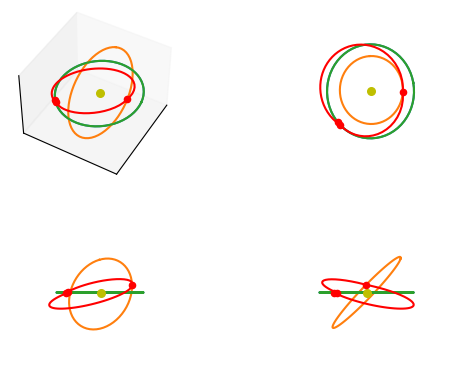

In [11]:
fig =  plt.figure()

ax = fig.add_subplot(2,2,1,projection="3d")
ax = udp.plot(pop.champion_x, ax=ax)
ax.view_init(45,30)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_zaxis().set_ticks([])

ax = fig.add_subplot(2,2,2,projection="3d")
ax = udp.plot(pop.champion_x, ax=ax)
ax.view_init(90,0)
ax.axis('off')

ax = fig.add_subplot(2,2,3,projection="3d")
ax = udp.plot(pop.champion_x, ax=ax)
ax.view_init(0,0)
ax.axis('off')

ax = fig.add_subplot(2,2,4,projection="3d")
ax = udp.plot(pop.champion_x, ax=ax)
ax.view_init(0,90)
ax.axis('off')

